# Breast Cancer with TensorFlow

In [257]:
# General
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Modeling
import tensorflow as tf
from sklearn.model_selection import train_test_split
from fast_ml.model_development import train_valid_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input

# Model Hypertunning
import kerastuner as kt

# Model Evaluation
from sklearn.metrics import confusion_matrix, classification_report


In [258]:
# Random Seed
random_seed = 42 # set random seed for reproducibility
tf.random.set_seed(random_seed) # set random seed for TensorFlow
np.random.seed(random_seed) # set random seed for NumPy

## Data

In [259]:
df = pd.read_csv('datasets/mf_df_2_breast_cancer.csv')
df

,Id,Clump_thickness,Uniformity_cell_size,Uniformity_cell_shape,Marginal_adhesion,Single_e_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2.0,1,1,1,2
695,841769,2,1,1,1,2,1.0,1,1,1,2
696,888820,5,10,10,3,7,3.0,8,10,2,4
697,897471,4,8,6,4,3,4.0,10,6,1,4


In [260]:
df.drop('Id', axis=1)

,Clump_thickness,Uniformity_cell_size,Uniformity_cell_shape,Marginal_adhesion,Single_e_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses,Class
0,5,1,1,1,2,1.0,3,1,1,2
1,5,4,4,5,7,10.0,3,2,1,2
2,3,1,1,1,2,2.0,3,1,1,2
3,6,8,8,1,3,4.0,3,7,1,2
4,4,1,1,3,2,1.0,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2.0,1,1,1,2
695,2,1,1,1,2,1.0,1,1,1,2
696,5,10,10,3,7,3.0,8,10,2,4
697,4,8,6,4,3,4.0,10,6,1,4


In [261]:
df.head()

,Id,Clump_thickness,Uniformity_cell_size,Uniformity_cell_shape,Marginal_adhesion,Single_e_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


In [262]:
target_column='Class'

In [263]:
n_classes = len(df[target_column].unique())
n_classes = 1 if n_classes == 2 else n_classes
n_classes

1

In [264]:
df[target_column].replace(to_replace={2:0, 4:1}, inplace=True)

In [265]:
# y_train = np.array(df[target_column]) # value dari label
# df = df.drop(target_column, axis=1) # drop target
# feature_list = list(df.columns) # list column
# X_train = np.array(df) # df dalam bentuk numpy array

In [266]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, target=target_column, train_size=0.6, valid_size=0.2, test_size=0.2, random_state=random_seed)
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=random_seed)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(419, 10) (419,)
(140, 10) (140,)
(140, 10) (140,)


In [267]:
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)

## Modeling

In [268]:
LEARNING_RATE = 0.001
BATCH_SIZE = 16
EPOCHS = 50
AUTOTUNE = tf.data.AUTOTUNE # Set to optimize the buffer size automatically
OUTPUT_ACTIVATION = 'sigmoid'
LOSS = tf.keras.losses.BinaryCrossentropy()
# LOSS = tf.keras.losses.BinaryCrossentropy(from_logits=True),
OPTIMIZER = Adam(learning_rate=LEARNING_RATE)

In [269]:
tf.keras.backend.clear_session() # clean session
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1], )),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(1, activation=OUTPUT_ACTIVATION)
])

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
            #   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=LOSS,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3,457
Trainable params: 3,457
Non-trainabl

In [270]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_valid,y_valid),
                    epochs=EPOCHS,
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ModelCheckpoint("model/breast_neural.h5", save_best_only=True)
                    ],
                    batch_size=BATCH_SIZE
                    )

Epoch 1/50
27/27 [==============================] - 1s 9ms/step - loss: 0.6562 - accuracy: 0.6874 - val_loss: 0.5917 - val_accuracy: 0.9071
Epoch 2/50
27/27 [==============================] - 0s 5ms/step - loss: 0.5735 - accuracy: 0.8687 - val_loss: 0.4871 - val_accuracy: 0.9286
Epoch 3/50
27/27 [==============================] - 0s 4ms/step - loss: 0.4893 - accuracy: 0.9189 - val_loss: 0.4107 - val_accuracy: 0.9571
Epoch 4/50
27/27 [==============================] - 0s 4ms/step - loss: 0.4119 - accuracy: 0.9260 - val_loss: 0.3300 - val_accuracy: 0.9714
Epoch 5/50
27/27 [==============================] - 0s 4ms/step - loss: 0.3249 - accuracy: 0.9475 - val_loss: 0.2565 - val_accuracy: 0.9714
Epoch 6/50
27/27 [==============================] - 0s 4ms/step - loss: 0.3222 - accuracy: 0.9427 - val_loss: 0.2129 - val_accuracy: 0.9429
Epoch 7/50
27/27 [==============================] - 0s 4ms/step - loss: 0.2411 - accuracy: 0.9570 - val_loss: 0.1741 - val_accuracy: 0.9714
Epoch 8/50
27/27 [==

## Hyptertuning

In [271]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                           activation=hp.Choice('activation', values=['relu', 'sigmoid'])))
    model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(tf.keras.layers.Dense(units=1, activation='linear'))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                  loss=LOSS, metrics=['accuracy'])
    return model

# Define the Keras Tuner RandomSearch object with the above parameters
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    # directory='my_dir',
    project_name='my_project'
)


In [274]:
# Fit the RandomSearch object to the data
tuner.search(X_train, y_train,
             epochs=10,
             validation_split=0.2,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

# Print the best hyperparameters
print("Best hyperparameters: ", tuner.get_best_hyperparameters(num_trials=1)[0].values)

INFO:tensorflow:Oracle triggered exit
Best hyperparameters:  {'units': 320, 'activation': 'relu', 'dropout': 0.0, 'optimizer': 'rmsprop'}


In [277]:
# Collect the best model Xception Model Architecture obtained by Random Searcher
best_model = tuner.get_best_models(num_models=1)[0]

# Compile Model
best_model.compile(
    loss=LOSS,
    optimizer=Adam(LEARNING_RATE*0.1),
    metrics=['accuracy']
)

# Model Training
best_model_history = best_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs = EPOCHS,
    batch_size = BATCH_SIZE*2,
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint("BestBasicNNModel.h5", save_best_only=True)
    ]
)

Epoch 1/50
14/14 [==============================] - 1s 14ms/step - loss: 0.1138 - accuracy: 0.9618 - val_loss: 0.0922 - val_accuracy: 0.9643
Epoch 2/50
14/14 [==============================] - 0s 5ms/step - loss: 0.1047 - accuracy: 0.9618 - val_loss: 0.0912 - val_accuracy: 0.9571
Epoch 3/50
14/14 [==============================] - 0s 5ms/step - loss: 0.1047 - accuracy: 0.9618 - val_loss: 0.0909 - val_accuracy: 0.9500
Epoch 4/50
14/14 [==============================] - 0s 5ms/step - loss: 0.1031 - accuracy: 0.9618 - val_loss: 0.0907 - val_accuracy: 0.9500
Epoch 5/50
14/14 [==============================] - 0s 6ms/step - loss: 0.1020 - accuracy: 0.9618 - val_loss: 0.0905 - val_accuracy: 0.9500
Epoch 6/50
14/14 [==============================] - 0s 9ms/step - loss: 0.1013 - accuracy: 0.9618 - val_loss: 0.0904 - val_accuracy: 0.9500
Epoch 7/50
14/14 [==============================] - 0s 5ms/step - loss: 0.0999 - accuracy: 0.9618 - val_loss: 0.0900 - val_accuracy: 0.9500
Epoch 8/50
14/14 [=

In [279]:
# Model Architecture
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 320)               3520      
                                                                 
 dropout (Dropout)           (None, 320)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 321       
                                                                 
Total params: 3,841
Trainable params: 3,841
Non-trainable params: 0
_________________________________________________________________


In [280]:
model = best_model

## Model Evaluation

In [281]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f'Test Loss is {test_loss}')
print(f'Test Accuracy is {test_acc}')

5/5 [==============================] - 0s 3ms/step - loss: 0.0642 - accuracy: 0.9786
Test Loss is 0.06416680663824081
Test Accuracy is 0.9785714149475098


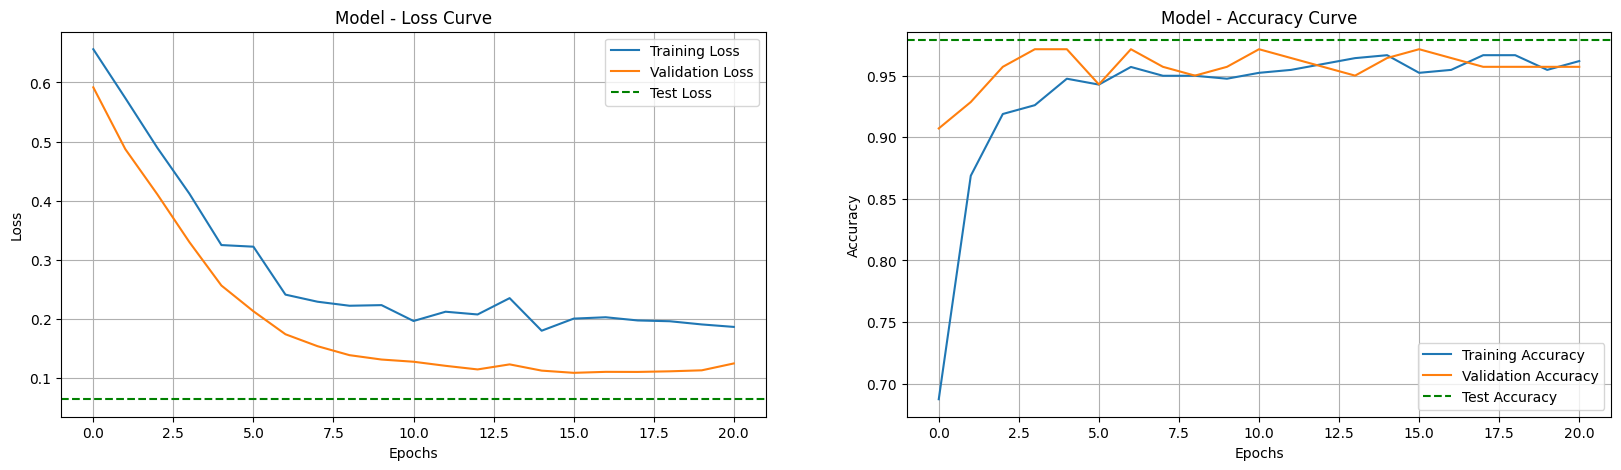

In [282]:
# Collect the history of the training run
plot_history = pd.DataFrame(history.history)

# Create a figure to display the model's performance
plt.figure(figsize=(20, 5))

# Plot the loss curve in the first subplot
plt.subplot(1, 2, 1)
plt.title("Model - Loss Curve")
plt.plot(plot_history['loss'], label="Training Loss")
plt.plot(plot_history['val_loss'], label="Validation Loss")

# Horizontal line to show the testing performance
plt.axhline(y=test_loss, label="Test Loss", linestyle='--', color='green')

# Set the x- and y-labels, and the x- and y-limits
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.ylim([0, 0.4])

# Show the legend and grid
plt.legend()
plt.grid()

# Plot the accuracy curve in the second subplot
plt.subplot(1, 2, 2)
plt.title("Model - Accuracy Curve")
plt.plot(plot_history['accuracy'], label="Training Accuracy")
plt.plot(plot_history['val_accuracy'], label="Validation Accuracy")

# Horizontal line to show the testing performance
plt.axhline(y=test_acc, label="Test Accuracy", linestyle='--', color='green')

# Set the x- and y-labels, and the x- and y-limits
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
# plt.ylim([0.85, 1])

# Show the legend and grid
plt.legend()
plt.grid()

# Display the plot
plt.show()

In [ ]:
predict=model.predict(X_test)

y_pred=[]
for i in range(len(predict)):
    y_pred.append(0 if predict[i] < 0.5 else 1)

3/3 [==============================] - 0s 2ms/step


In [ ]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.82      0.90        45
           1       0.76      1.00      0.86        25

    accuracy                           0.89        70
   macro avg       0.88      0.91      0.88        70
weighted avg       0.91      0.89      0.89        70



3/3 [==============================] - 0s 2ms/step


Text(0.5, 36.72222222222221, 'Predicted label')

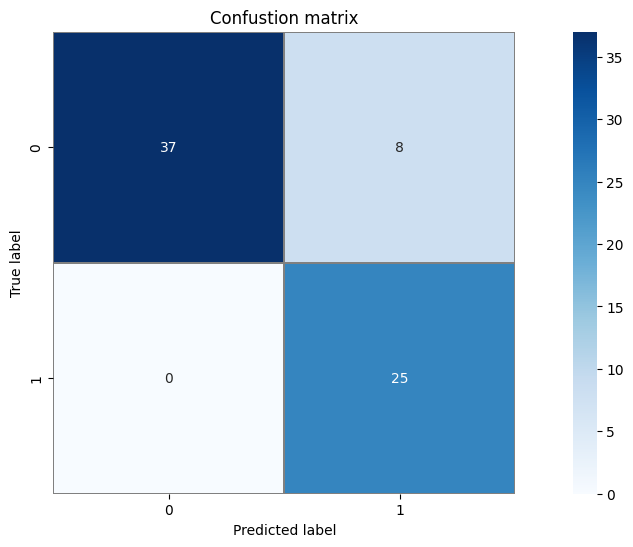

In [ ]:
p_test = model.predict(X_test).argmax(axis=1)
cm = tf.math.confusion_matrix(y_test, y_pred)

f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(cm, annot=True, cmap='Blues', square=True, linewidths=0.01, linecolor='grey')
plt.title('Confustion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')